### 1. Introduction

** Lending Club** is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. Each borrower fills out a comprehensive application, providing their past financial history, the reason for the loan, and more. Lending Club evaluates each borrower’s credit score using past historical data (and their own data science process!) and assigns an interest rate to the borrower.

### 2. Objection

We need evaluate each borrower’s credit core using these historical data and assigns the interests rate to the borrower.Investors are primarily interested in receiving a return on their investments. Therefore we need to build a machine learning model which can reliably predict if a loan will be paid off or not, since many conservative investor only wants to invest in loans that have a good chance of being paid off on time. 

### 3. Examining the Data Set 

Lending Club releases data for all the approved and declined loan applications on their website： https://www.lendingclub.com/info/download-data.action

The data dictionary contains two sheets:
* LoanStats sheet: describes the approved loans dataset
* RejectStats sheet: describes the rejected loans dataset

Using the LoanStats sheet which contains the approved loans dataset.

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

loans_2007 = pd.read_csv('LoanStats3a.csv', skiprows=1, low_memory=False) 
## Summary data 
loans_2007.info()
loans_2007.shape
loans_2007.columns # output as array
loans_2007.columns.tolist() # output as list 
loans_2007.head()

### 4. Data Cleaning

* Remove the first line: It contains useless text instead of the column titles. 

* Remove the ‘desc’ column: it contains a long text explanation for the loan.

* Remove the ‘url’ column: it contains a link which can only be accessed with an investor account.

* Removing all columns with more than 50% missing values: This allows us to move faster since don’t need to spend time trying to fill these values.


In [ ]:
## Drop columns which contains NA over than m 
half_count = len(loans_2007) / 2
loans_2007 = loans_2007.dropna(thresh=half_count,axis=1) # Drop any column with more than 50% missing values
loans_2007 = loans_2007.drop(['url','desc'],axis=1)  

df = loans_2007
## Renaem col_names 
df = df.rename(columns = {'old_col_name1': 'new_col_name1','old_col_name2': 'new_col_name2' })

## Create new df contans df.dtype, which gives a Series about df.columns.
df1 = pd.DataFrame(df.dtypes, columns = 'type')

## Rest index from 0,1,2...
df1 = df1.reset_index ()

## Add new colunms from df.one_col
df1['new_col'] = df["one_col"]

## Add new columns from first row df
df1['new_col'] = df.loc[0].values ## df.loc[0] actrually gives a series output, which needs to transverse to array

## Merge two df with same column 
merge = df.merge(df1, on = 'same_column', how = 'left')


### 5. Feature Selection 

*It is very important to spend some time to familiarize the columns in the dataset, to understand what each feature represents!!!*

Remove the columns having below problems:

1) leaks information from the future (after the loan has already been funded) 

2) don’t affect the borrower’s ability to pay back the loan 

3) formatted poorly

4) requires more data or a lot of preprocessing to turn into useful a feature

5) contains redundant information.

** Data leakage can cause the model to overfit **


In [ ]:
## return the frequency of the unique values in the loan_status column.
df['col'].value_counts()

data_dictionary = pd.read_csv('LCDataDictionary.csv') # Loading in the data dictionary
print(data_dictionary.shape[0])
print(data_dictionary.columns.tolist())

data_dictionary.head()
data_dictionary = data_dictionary.rename(columns={'LoanStatNew': 'name',
                                                 'Description': 'description'})

## remove the data leakage columns
drop_cols = ['total_rec_prncp','total_rec_int', 'total_rec_late_fee',
             'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
             'last_pymnt_amnt']

loans_2007 = loans_2007.drop(drop_cols, axis=1)


|LoanStatNew    |Description|
| ------------- |:-------------:|
|acc_now_delinq	|The number of accounts on which the borrower is now delinquent.
|acc_open_past_24mths	|Number of trades opened in past 24 months.
|addr_state	            |The state provided by the borrower in the loan application
|all_util	            |Balance to credit limit on all trades
|annual_inc	            |The self-reported annual income provided by the borrower during registration.

### 6. Visualizing the Target Column Outcomes

Using the loan_status column, since it's the only column that directly describes if a loan was paid off on time, had delayed payments, or was defaulted on the borrower. Currently, this column contains text values and we need to convert it to a numerical one for training a model. Let's explore the different values in this column and come up with a strategy for converting the values in this column.


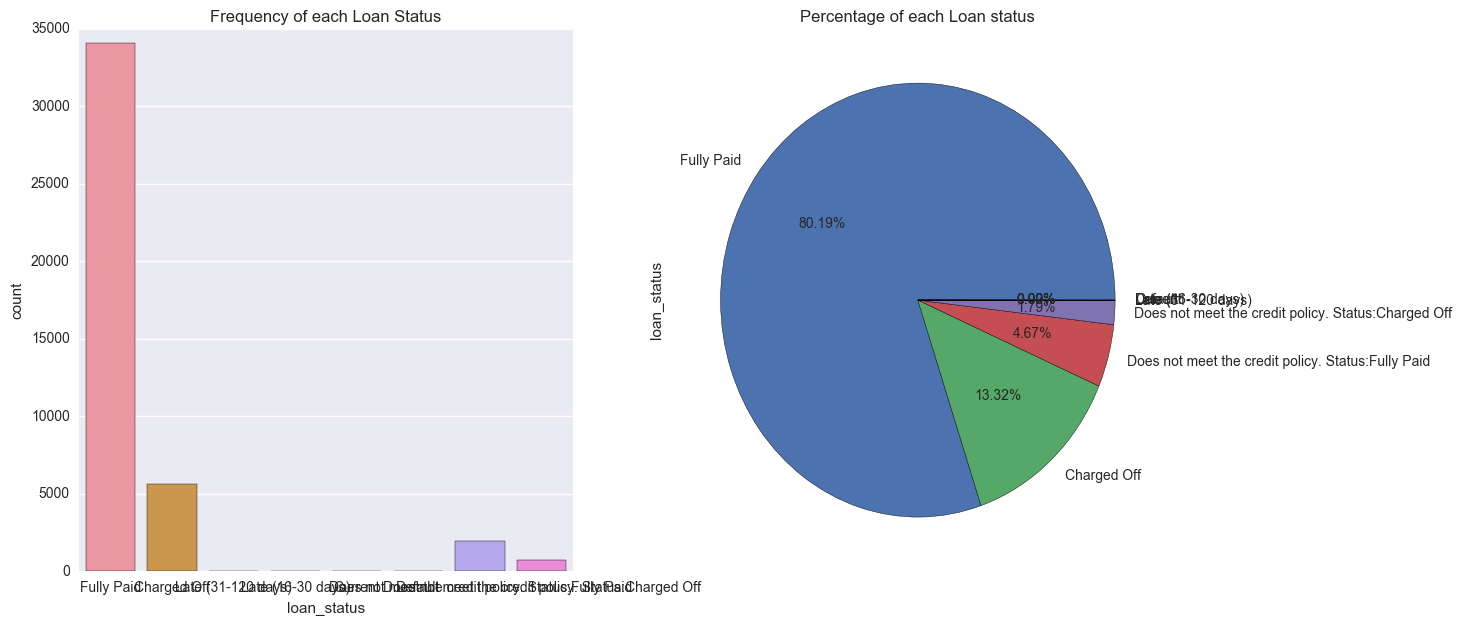

In [58]:
fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='loan_status',data=loans_2007,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
loans_2007.loan_status.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Loan status")
plt.show()


** We’re not interested in any statuses that indicate that the loan is ongoing or in progress, because predicting that something is in progress doesn’t tell us anything** 

** Since we’re interested in being able to predict which of these 2 values a loan will fall under, we can treat the problem as binary classification **



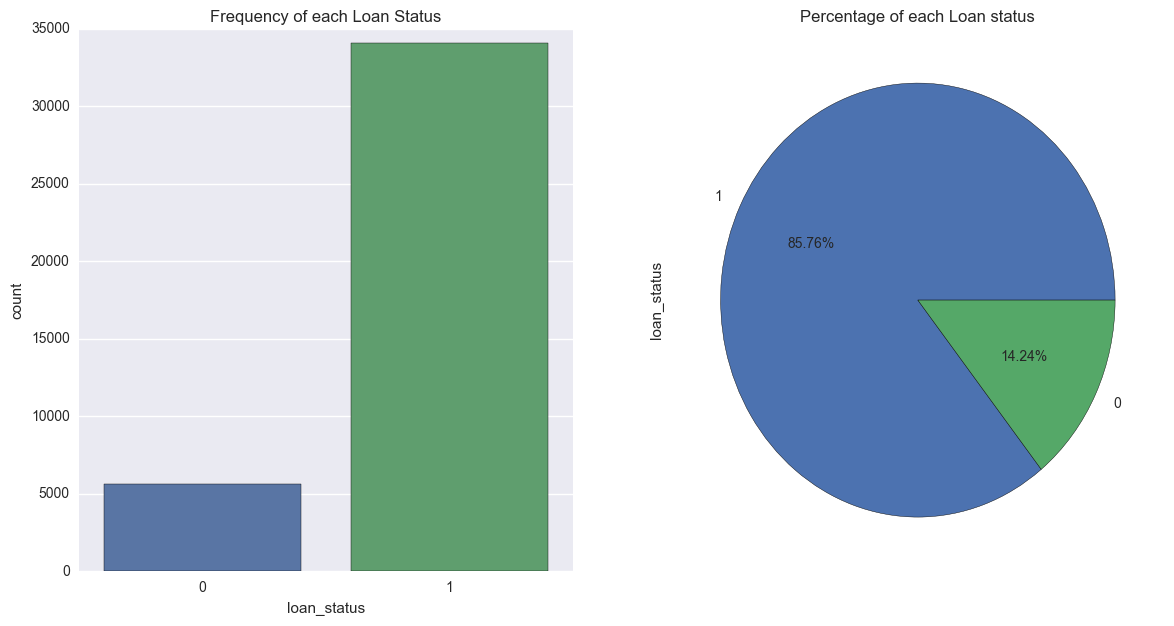

In [59]:
loans_2007 = loans_2007[(loans_2007["loan_status"] == "Fully Paid") |
                            (loans_2007["loan_status"] == "Charged Off")]

mapping_dictionary = {"loan_status":{ "Fully Paid": 1, "Charged Off": 0}}
filtered_loans = loans_2007.replace(mapping_dictionary)

fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='loan_status',data=filtered_loans,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
filtered_loans.loan_status.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Loan status")
plt.show()



#### These plots indicate that a significant number of borrowers in our dataset paid off their loan - 85.76% of loan borrowers paid off amount borrowed, while 14.24% unfortunately defaulted. From our loan data it is these ‘defaulters’ that we’re more interested in filtering out as much as possible to reduce loses on investment returns

### 7. Data Cleaning 

* Remove columns with only One Value
* Remove columns with more than one unique values but one of the values has insignificant frequency in the dataset

In [ ]:
## Remove Columns with only One Value
df = filtered_loans
df.loc[:, df.apply(pd.Series.nunique) !=1]

## Removw Columns with more than one unique values but one of the values has insignificant frequency in the dataset
for col in df.columns():
    if df.col.nunique < 4:
        print (df.col.valu_counts())
        print () ## Empty line
    

### 8. Preparing the Features for Machine Learning__Feature Engineering

We’ll focus on handling missing values, converting categorical columns to numeric columns and removing any other extraneous columns.

We need to **handle missing values and categorical features** before feeding the data into a machine learning algorithm, because the mathematics underlying most machine learning models assumes that the data is numerical and contains no missing values. To reinforce this requirement, scikit-learn will return an error if you try to train a model using data that contain missing values or non-numeric values when working with models like linear regression and logistic regression.

Here’s an outline of what we’ll be doing in this stage:

* Handle Missing Values
* Investigate Categorical Columns
   * Convert Categorical Columns To Numeric Features
      * Map Ordinal Values To Integers
      * Encode Nominal Values As Dummy Variables
    

** Handle Missing Values ** 

In [ ]:
## Calculate the number of null values in each column.
null_counts = df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

## Remove columns entirely where more than 1% of the rows for that column contain a null value
df = df.drop('col', axis =1)

## Remove all rows from df containing any missing values.
df = df.dropna()

** Investigate Categorical Columns **

Keep in mind, the goal in this section is to have ** all the columns as numeric columns (int or float data type)**, and ** containing no missing values **. We just dealt with the missing values, so let’s now find out the number of columns that are of the ** object data type ** and then move on to process them into numeric form.

In [ ]:
## find out the number of columns that are of the object data typ
print("Data types and their frequency\n{}".format(df.dtypes.value_counts()))

## Select just the object columns using the DataFrame method select_dtype, 
## then display a sample row to get a better sense of how the values in each column are formatted.
object_df = df.select_dtypes(include=['object'])
print (object_df.iloc[0])

## Covert string like '45%' to float type 0.45 
df['revol_util'] = df['revol_util'].str.rstrip('%').astype('float')


** Convert Categorical Columns to Numeric Features **

*** Ordinal Values ***: These categorical values are in natural order. That’s you can sort or order them either in increasing or decreasing order. 

*** Nominal Values ***: These are regular categorical values. You can’t order nominal values. For instance, while we can order loan applicants in the employment length column (emp_length) based on years spent in the workforce:
year 1 < year 2 < year 3 … < year N,

Most of discrete categorical,Nominal Values s which we can encode as dummy variables and keep. For thoese contained too many unique values, it’s better to drop this.

In [ ]:
## To map the ordinal values to integers, 
## use the pandas DataFrame method replace() to map to appropriate numeric values

mapping_dict = {
    "col_name1": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
 
    },
    "col_name2":{
        "A": 1,
        "B": 2,
        "C": 3,
        "D": 4,
        "E": 5,
        "F": 6,
        "G": 7
    }
}

df = df.replace(mapping_dict)

## To converting nominal features into numerical features is to encode them as dummy variables. 
nominal_values_columns =['name1','name2',...]
## Use pd.get_dummies() method to return a new DataFrame containing a new column for each dummy variable
dummy_df = pd.get_dummies(df[nominal_values_columns])
## Use the concat() method to add these dummy columns back to the original DataFrame
df = pd.concat([df, dummy_df], axis=1)
## Drop the original columns entirely using the drop method
df = df.drop(nominal_values_columns, axis =1) 

df.info()


** Then, we performed the last amount of data preparation necessary to get the features into data types that can be fed into machine learning algorithms ** 

** We converted all columns of object data type(Categorical features) to numerical values because those are the only type of values scikit-learn can work with. ** 

### 9. Machine learning - Logistic Regression

For binary classification problems:

* quick to train and we can iterate more quickly,
* not easily overfitting than more complex models like decision trees,
* easy to interpret

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
features = filtered_loans.drop("loan_status", axis =1) 
target = filtered_loans.loan_status  
lr.fit(features,target)
predictions = lr.predict(features)

** There is a significant class imbalance in the loan_status column. There are 6 times as many loans that were paid off on time (1), than loans that weren't paid off on time (0). So we can't use accuracy as a metric **

There are two ways to get a classifier to correct for imbalanced classes: 

* Use oversampling and undersampling to ensure that the classifier gets input that has a balanced number of each class.
* Tell the classifier to ** penalize misclassifications **of the less prevalent class more than the other class.

* penalty = { 0:10, 1:1 }
* LogisticRegression(class_weight= penalty)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_predict
penalty = { 0:10, 1:1 }
lr = LogisticRegression(class_weight= penalty)

kf = KFold(features.shape[0], random_state =1)

predictions = cross_val_predict(lr, features, target, cv=kf)
predictions = pd.Series(predictions)

# False positives.
fp_filter = (predictions == 1) & (loans["loan_status"] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (loans["loan_status"] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (loans["loan_status"] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (loans["loan_status"] == 0)
tn = len(predictions[tn_filter])

# Rates
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(tpr)
print(fpr)

Significantly improved false positive rate by balancing the classes, which reduced true positive rate. 

** Our true positive rate is now around 67%, and our false positive rate is around 40% ** For a conservative investor, lower false positive rate  means that we'll be able to do a better job at avoiding bad loans than if we funded everything. 

** However, we'd only ever decide to fund 67% of the total loans (true positive rate), so we'd immediately reject a good amount of loans, By turning the paramentrer, finally we can lowered the false positive rate to 7%, and thus lowered our risk. **

While we have fewer false positives, we're also missing opportunities to fund more loans and potentially make more money. 

** Try Random Forests! **


### 10. Machine learning - Random Forests

Random forests are able to work with nonlinear data, and learn complex conditionals. Logistic regressions are only able to work with linear data. 

Training a random forest algorithm may get more accuracy due to columns that correlate nonlinearly with loan_status.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_predict

rf = RandomForestClassifier(class_weight = "balanced", random_state=1)

kf = KFold(features.shape[0], random_state=1)

predictions = cross_val_predict(rf, features, target, cv=kf)
predictions = pd.Series(predictions)

# False positives.
fp_filter = (predictions == 1) & (loans["loan_status"] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (loans["loan_status"] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (loans["loan_status"] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (loans["loan_status"] == 0)
tn = len(predictions[tn_filter])

# Rates
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(tpr)
print(fpr)
0.971806726498051
0.9330365093499555

### 11. Conclusion

Using a random forest classifier didn't improve our false positive rate. ** Ultimately, our best model had a false positive rate of 7%, and a true positive rate of 20%**. 

For a conservative investor, this means that they make money as long as the interest rate is high enough to offset the losses from 7% of borrowers defaulting, and that the pool of 20% of borrowers is large enough to make enough interest money to offset the losses.

### 12. Improve

There's still quite a bit of room to improve:

* We can try models other than a random forest and logistic regression.
* We can use some of the columns we discarded to generate better features.
* We can ensemble multiple models to get more accurate predictions.
* We can tune the parameters of the algorithm to achieve higher performance.